In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
from scipy.stats import gmean
from xbbg import blp
import sys
sys.path.append(r'\\10.5.20.31\交易部\Blair\backTestTool')
sys.path.append(r'\\10.5.20.31\交易部\FX trading Strategy souce code\Wilson\程式碼')


import sys
from contextlib import contextmanager
import io
import os

# Add this at the beginning of your code, after the imports
strgyName = '1105'
traderName = 'Blair'


devCcy =  ['EUR', 'JPY', 'GBP', 'CHF', 'AUD', 'CAD', 'NZD', 'SEK']
revL = ['NZD', 'EUR', 'AUD', 'GBP']
basket = devCcy
#########################################
from datetime import datetime
today = datetime.now()+pd.Timedelta(days=0)
today_str = today.strftime('%Y-%m-%d')
# startDate = today-pd.Timedelta(days=600)
startDate = '2012-01-01'

# startDate = startDate.strftime('%Y-%m-%d')
endDate = today_str

dr = pd.date_range(
    start=pd.to_datetime(startDate),
    end=pd.to_datetime(endDate),
    freq=BDay()
)  

ohlcD = np.load('ohlc_BGN_EM.npy',allow_pickle='TRUE').item()
spot = pd.DataFrame(index=dr, columns=basket)
for col in spot.columns:
    spot[col] = ohlcD[col]['PX_LAST']

df = pd.DataFrame(index=dr)
df['close'] = spot['JPY']

gotobiL = [5, 10, 15, 20, 25, 30]
gotobiD = dict.fromkeys(gotobiL)

'''
根據https://oec.world/en/profile/country/jpn?yearlyTradeFlowSelector=flow1的資料，日本自: 中國、美國、德國
以及澳洲進口商品
'''
jpImportCcys = ['USDJPY', 'CNHJPY', 'EURJPY', 'AUDJPY']

In [7]:

# ## get market data
# from xbbg import blp

# basket = jpImportCcys
# ohlcTickers = [ f'{i} CMTK Curncy' for i in basket]
# ohlc = pd.DataFrame(columns=basket)

# instruments = ohlcTickers

# ohlcD = dict.fromkeys(basket)
# for k in ohlcD.keys():
#     ohlcD[k] = pd.DataFrame(columns=['PX_OPEN', 'PX_LAST', 'PX_LOW', 'PX_HIGH'])

# count = 0
# for i in instruments:
#     for fld in ['PX_OPEN', 'PX_LAST', 'PX_LOW', 'PX_HIGH']:
#         tmpS = blp.bdh(tickers=instruments[count], flds=fld, start_date=startDate, end_date=endDate)
#         ohlcD[basket[count]][fld] = tmpS
#         tmpIdx = tmpS.index
#         ohlcD[basket[count]].index = pd.DatetimeIndex(ohlcD[basket[count]].index)
#         # if fld == 'PX_HIGH':
#         #     ohlcD[basket[count]].index = tmpIdx
#     count += 1

# ohlc.index = pd.DatetimeIndex(ohlc.index)
# np.save('ohlc_cross_JPY.npy', ohlcD)

In [8]:
# backtest
ohlcD = np.load('ohlc_cross_JPY.npy',allow_pickle='TRUE').item()
spot = pd.DataFrame(index=dr, columns=basket)
for col in spot.columns:
    spot[col] = ohlcD[col]['PX_LAST']
spot.tail()

,USDJPY,CNHJPY,EURJPY,AUDJPY
2025-03-17,148.84,20.5505,161.88,94.335
2025-03-18,149.83,20.7330,163.85,95.602
2025-03-19,149.28,20.6225,162.63,94.507
2025-03-20,148.59,20.5185,161.66,93.921
2025-03-21,149.31,20.5879,161.84,93.997


In [63]:
tmpDr = pd.date_range(
    start=pd.to_datetime(startDate),
    end=pd.to_datetime(endDate),
    freq=Day()
)  
tmpDr

DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05', '2012-01-06', '2012-01-07', '2012-01-08',
               '2012-01-09', '2012-01-10',
               ...
               '2025-03-14', '2025-03-15', '2025-03-16', '2025-03-17',
               '2025-03-18', '2025-03-19', '2025-03-20', '2025-03-21',
               '2025-03-22', '2025-03-23'],
              dtype='datetime64[ns]', length=4831, freq='D')

In [66]:
import pandas as pd
from pandas.tseries.offsets import BDay
from pandas.tseries.holiday import USFederalHolidayCalendar, Holiday
import numpy as np

def adjust_gotobi_dates(dr, gotobiL, openOrClose, calendar=None):
    """
    Adjusts Gotobi dates to account for weekends and holidays.
    
    Parameters:
    dr (DatetimeIndex): Date range for the strategy
    gotobiL (list): List of Gotobi days (5, 10, 15, 20, 25, 30)
    calendar (CustomBusinessDay, optional): Custom business day calendar with holidays
    
    Returns:
    tuple: (open_dates, close_dates) - dictionaries mapping original dates to adjusted dates
    """
    # Initialize calendars
    if calendar is None:
        # Default to US Federal holidays if no calendar provided
        calendar = pd.offsets.CustomBusinessDay(calendar=USFederalHolidayCalendar())
    
    # Create business day offset for calculations
    bday = BDay()
    
    # Extract all dates from dr
    all_dates = dr.to_list()
    
    # Create dictionaries to store original and adjusted dates
    positions = {}  # For opening positions (day before Gotobi)
    
    if openOrClose == 'open':
    # Process each month in the date range
        for date in dr:
            # Check if the day is a Gotobi target day
            day = date.day
            if day in gotobiL:
                # Original position opening date (day before Gotobi)
                day_before = date - pd.Timedelta(days=1)
                
                # Adjust if it falls on weekend or holiday
                while day_before not in all_dates or day_before.dayofweek >= 5:
                    day_before = day_before - pd.Timedelta(days=1)
                
                # Apply business day adjustment to ensure it's a valid trading day
                day_before = day_before.normalize()
                day_before_adjusted = day_before
                while day_before_adjusted not in all_dates:
                    day_before_adjusted = (day_before_adjusted - bday).normalize()
                positions[date] = day_before_adjusted

    if openOrClose == 'close':
        for date in dr:
            # Check if the day is a Gotobi target day
            day = date.day
            if day in gotobiL:
                # Original position closing date (Gotobi day)
                day_of = date
                
                # Adjust if it falls on weekend or holiday
                while day_of not in all_dates or day_of.dayofweek >= 5:
                    day_of = day_of + pd.Timedelta(days=1)
                
                # Apply business day adjustment to ensure it's a valid trading day
                day_of = day_of.normalize()
                day_of_adjusted = day_of
                while day_of_adjusted not in all_dates:
                    day_of_adjusted = (day_of_adjusted + bday).normalize()

                positions[date] = day_of_adjusted
    return positions

In [108]:
# target day=5
from scipy.stats import skew, kurtosis
stats_all = pd.DataFrame(index=gotobiL)
# stats_dict = dict.fromkeys(gotobiL)
testCcy = 'CNHJPY'

for d in gotobiL:
    # print(d)
    tmp = [d]
    stats = pd.DataFrame(columns=['enterDate', 'enterRate', 'exitDate', 'exitRate', 'ret'])
    stats['enterDate'] = adjust_gotobi_dates(dr=tmpDr, openOrClose='open', gotobiL=tmp).values()
    stats['enterRate'] = spot.loc[stats['enterDate']][testCcy].reset_index(drop=True)

    stats['exitDate'] = adjust_gotobi_dates(dr=tmpDr, openOrClose='close', gotobiL=tmp).values()
    stats['exitRate'] = spot.loc[stats['exitDate']][testCcy].reset_index(drop=True)
    stats['ret'] = (stats['exitRate'] - stats['enterRate'])/stats['enterRate']
    
    stats_all.loc[d, 'ret_mid(%)'] = round(stats['ret'].median()*100, 2)
    # stats_all.loc[d, 'ret_skew'] = skew(stats['ret'])
    # stats_all.loc[d, 'ret_kurt'] = kurtosis(stats['ret'])
    stats_all.loc[d, 'ret_max(%)'] = round(stats['ret'].max()*100, 2)
    stats_all.loc[d, 'ret_min(%)'] = round(stats['ret'].min()*100, 2)
    

(array([ 7., 14., 26., 31., 24., 28.,  7.,  2.,  2.,  2.]),
 array([-0.01057848, -0.00763575, -0.00469303, -0.0017503 ,  0.00119242,
         0.00413515,  0.00707788,  0.0100206 ,  0.01296333,  0.01590605,
         0.01884878]),
 <BarContainer object of 10 artists>)

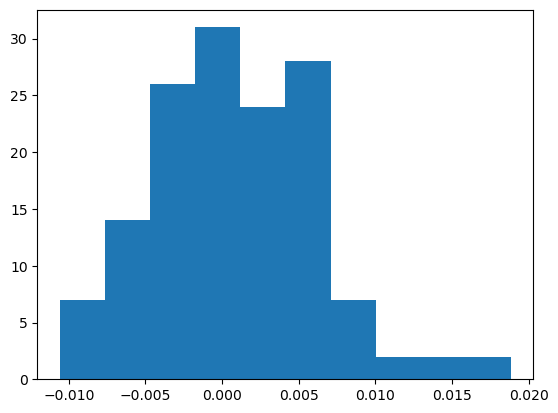

In [110]:
plt.hist(stats['ret'])

In [107]:
stats_all

,ret_mid(%),ret_max(%),ret_min(%)
5,-0.09,1.86,-2.54
10,0.11,1.58,-1.35
15,-0.02,1.55,-1.61
20,0.06,1.93,-2.53
25,0.01,2.22,-1.84
30,0.06,2.35,-1.09


In [ ]:
fefefe

In [112]:
filterDf = pd.DataFrame(index=dr)

dxy = blp.bdh(tickers='JPY CMTK Curncy', flds = ["PX_LAST"], start_date=startDate, end_date=endDate)
dxy.index = pd.DatetimeIndex(dxy.index)
dxy = dxy.reindex(dr).ffill()

filterDf['dxy'] = dxy

filterDf['USDJPY_MA_fast'] = filterDf['dxy'].rolling(window=40).mean()
filterDf['USDJPY_MA_slow'] = filterDf['dxy'].rolling(window=100).mean()
notGoodDay = filterDf[filterDf['USDJPY_MA_fast'] < filterDf['USDJPY_MA_slow']].index 


signalDf = pd.DataFrame(0, index=dr, columns=basket) 
for targetDay in gotobiL:
    signalDf.loc[signalDf.index.day == (targetDay-1), 'JPY'] = 1
    signalDf.loc[signalDf.index.day == (targetDay), 'JPY'] = 0

signalDf[signalDf.index.isin(notGoodDay)] = 0

weight_size = 2
# signalDf = signalDf * weight_size   


In [114]:
signalDf

,USDJPY,CNHJPY,EURJPY,AUDJPY,JPY
2012-01-02,0,0,0,0,NaN
2012-01-03,0,0,0,0,NaN
2012-01-04,0,0,0,0,1.0
2012-01-05,0,0,0,0,0.0
2012-01-06,0,0,0,0,NaN
...,...,...,...,...,...
2025-03-17,0,0,0,0,0.0
2025-03-18,0,0,0,0,0.0
2025-03-19,0,0,0,0,0.0
2025-03-20,0,0,0,0,0.0
